# Train a Multi-Layer-Perceptron Model to Predict Energy Curves

use merged data

In [1]:
from pathlib import Path
from ipywidgets import interact, fixed
import vprd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import lightning as pl
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.callbacks import EarlyStopping
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# figure parameters
plt.rcParams['svg.fonttype'] = 'none'  # makes text editable in svg
plt.rcParams['font.size'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = plt.rcParams['xtick.labelsize']

# figure sizes
textwidth = 7.05  # inches
onecolumn = 3.42  # inches
# set the default figure size to one column width
plt.rcParams['figure.figsize'] = (onecolumn, onecolumn)

## Load and prepare the data

In [2]:
data_path = Path('../../data')
local_data_path = Path(data_path / 'cloud/')
energy_file = local_data_path / 'electron_power_data_files_114_115_116_117.hdf5'

# ensure the data is downloaded (if not already)
vprd.data.ensure_local(energy_file)

#load the energy data
df = pd.read_hdf(energy_file, key='df')
df

,index,TrainId,Electron_power,/FLASH_SDIAG/BCM_DAQ/FL0_DBC1_1/COMPRESSION_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC1_1/COMPRESSION_normalized_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC1_2/COMPRESSION_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC1_2/COMPRESSION_normalized_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC2_1/COMPRESSION_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC2_1/COMPRESSION_normalized_TD,/FLASH_SDIAG/BCM_DAQ/FL0_DBC2_2/COMPRESSION_TD,...,/FLASH_SDIAG/BAM_DAQ/FL0_DBC2_ARRIVAL_TIME_RELATIVE/Value,/FLASH_SDIAG/BAM_DAQ/FL0_UBC1_ARRIVAL_TIME_RELATIVE/Value,/FLASH_SDIAG/BAM_DAQ/FL0_UBC2_ARRIVAL_TIME_RELATIVE/Value,/FLASH_SDIAG/BAM_DAQ/FL2_SEED5_ARRIVAL_TIME_RELATIVE/Value,/FLASH_DIAG/TOROID/7FL2XTDS/CHARGE_TD,/FLASH_DIAG/BPM/9FL2XTDS/CHARGE_TD,/FLASH_DIAG/BPM/9FL2XTDS/X_TD,/FLASH_DIAG/BPM/9FL2XTDS/Y_TD,/FLASH_SDIAG/BAM_DAQ/FL0_DBC_ARRIVAL_TIME_1_DELTA/Value,/FLASH_SDIAG/BAM_DAQ/FL0_DBC_ARRIVAL_TIME_2_DELTA/Value
0,0,1942830449,"[1662811600.0, 1349448800.0, 1751699800.0, 181...",0.013977,0.348380,0.091400,2.278164,0.074997,1.845281,0.121796,...,-220.290619,104.842995,61.064560,0.000000,0.19975,0.312712,3.350192,0.666741,-158.124146,-281.355164
1,1,1942830450,"[1967650400.0, 2245198300.0, 2240654300.0, 259...",0.013916,0.346859,0.091583,2.282728,0.070892,1.739970,0.117287,...,-261.015320,155.832520,64.939682,0.000000,0.20020,0.313796,3.352160,0.641766,-212.231873,-325.955017
2,2,1942830451,"[1386138800.0, 1067803460.0, 1238563600.0, 124...",0.014160,0.356138,0.090637,2.279587,0.069534,1.720248,0.113998,...,-264.227295,118.235802,38.283401,0.000000,0.19915,0.311799,3.350848,0.631928,-182.867188,-302.510681
3,3,1942830452,"[1033531300.0, 1054784450.0, 1347648800.0, 166...",0.014252,0.356649,0.091309,2.284999,0.070473,1.739136,0.116226,...,-279.466400,121.219620,47.366535,0.000000,0.19920,0.312148,3.348224,0.605440,-180.267105,-326.832947
4,4,1942830453,"[1613813100.0, 1686847600.0, 1710520800.0, 148...",0.013397,0.338816,0.090607,2.291443,0.070549,1.769915,0.117233,...,-257.225800,125.389000,54.010460,0.000000,0.19805,0.309478,3.344944,0.613008,-149.830109,-311.236267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,701,1942833280,"[1545094400.0, 1464527400.0, 1686040400.0, 211...",0.013794,0.346406,0.091064,2.286891,0.069237,1.726600,0.116127,...,3199.421387,95.763153,50.104500,915.777893,0.19845,0.307937,3.297712,1.471219,-24.689453,3149.316895
2822,702,1942833281,"[1687414700.0, 1671712500.0, 1802142300.0, 171...",0.013336,0.336933,0.090881,2.296079,0.070290,1.757240,0.117294,...,3176.591797,70.574585,34.945549,913.403259,0.19795,0.307196,3.302304,1.437920,-18.579449,3141.646240
2823,703,1942833282,"[2133312600.0, 2140152700.0, 2141127400.0, 251...",0.012634,0.320326,0.090424,2.292573,0.074982,1.880179,0.119492,...,3217.532715,22.281994,84.973656,908.230225,0.19790,0.306707,3.303616,1.434893,85.547791,3132.559082
2824,704,1942833283,"[2425803300.0, 2622600400.0, 2758704600.0, 282...",0.012787,0.320312,0.091187,2.284229,0.071724,1.766502,0.118690,...,3214.079834,112.387871,112.746269,911.354187,0.19890,0.308870,3.304928,1.428082,13.353401,3101.333496


## Split the Data into training and test sets

the resulting data loaders can be directly used for training.

In [3]:
training_data_loader, validation_data_loader, test_data_loader = vprd.data.get_train_val_test_dataloader(df)
print(f"Batches in training data loader: {len(training_data_loader)}")
print(f"Batches in validation data loader: {len(validation_data_loader)}")
print(f"Batches in test data loader: {len(test_data_loader)}")
print(f"Number of samples in training data loader: {len(training_data_loader.dataset)}")
print(f"Number of samples in validation data loader: {len(validation_data_loader.dataset)}")
print(f"Number of samples in test data loader: {len(test_data_loader.dataset)}")
print(f"Total number of samples: {len(training_data_loader.dataset) + len(validation_data_loader.dataset) + len(test_data_loader.dataset)}")

Batches in training data loader: 1
Batches in validation data loader: 1
Batches in test data loader: 1
Number of samples in training data loader: 2261
Number of samples in validation data loader: 283
Number of samples in test data loader: 282
Total number of samples: 2826


## Determine input and output shape from the data

In [4]:
input_shape = vprd.get_input_shape(training_data_loader)
output_shape = vprd.get_output_shape(training_data_loader)
print(f"Input shape: {input_shape}, Output shape: {output_shape}")

Input shape: torch.Size([22]), Output shape: torch.Size([567])


## Create a Multi-Layer-Perceptron Model

In [5]:
penalty_weight = 0.1
mlp = vprd.EnergyPredictionMLPModel(input_shape, output_shape, learning_rate_scheduler_patience=200)
mlp.initialize_loss_function(training_data_loader, penalty_weight=penalty_weight)
mlp

EnergyPredictionMLPModel(
  (model): EnergyPredictionMLP(
    (layers): Sequential(
      (linear_0): Linear(in_features=22, out_features=294, bias=True)
      (relu_0): ReLU()
      (dropout_0): Dropout(p=0.5, inplace=False)
      (output): Linear(in_features=294, out_features=567, bias=True)
    )
  )
)

## Train the model

In [6]:
lr_monitor = LearningRateMonitor(logging_interval='step')
early_stopping = EarlyStopping(monitor='val_loss', patience=500)

# train the model on a gpu
trainer = pl.Trainer(max_epochs=-1, accelerator='gpu', log_every_n_steps=10, callbacks=[lr_monitor, early_stopping], enable_progress_bar=False)

# # in case you run into GPU errors in the next cell, train the model on a cpu by commenting out the line above and uncommenting the following line
# trainer = pl.Trainer(max_epochs=-1, accelerator='cpu', log_every_n_steps=10, callbacks=[ lr_monitor, early_stopping], enable_progress_bar=False)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(mlp, training_data_loader, validation_data_loader)


  | Name  | Type                | Params | Mode 
------------------------------------------------------
0 | model | EnergyPredictionMLP | 174 K  | train
------------------------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.696     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/Users/korten/Documents/workspace/VPRD/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/korten/Documents/workspace/VPRD/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argu

## Test the prediction quality

In [8]:
# predict the energy data
predictions = trainer.predict(mlp, test_data_loader)


/Users/korten/Documents/workspace/VPRD/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


In [9]:
train_data = next(iter(training_data_loader))
mean_data = train_data[1].numpy().mean(axis=0)
len(mean_data)

567

### Plot the results

we plot the predictions (blue line) vs the measured labels (orange line). In order to assess whether the model just predicts the mean of the training data, we also plot the mean of the training labels (green dotted line)

In [10]:
def plot_predictions(idx, predictions, test_data_loader, ax=None):
    def inverse_transform(data):
        return training_data_loader.dataset.dataset.inverse_transform(data) / 1e9  # in GW
    prediction = inverse_transform(predictions[idx])
    test_data = next(iter(test_data_loader))
    test_data_plot = inverse_transform(test_data[1][idx])
    test_data_previous = inverse_transform(test_data[1][idx - 1])
    vprd.image_processing.calibrated_lineplot(test_data_previous,  label='Neighboring shot', color='tab:green')
    vprd.image_processing.calibrated_lineplot(inverse_transform(mean_data), label='Mean training dataset', color='tab:orange')
    ax = vprd.image_processing.calibrated_lineplot(test_data_plot, 'Power (GW)', label='True data', color='tab:red')
    vprd.image_processing.calibrated_lineplot(prediction, label='Prediction', color='tab:blue')
    # plot the mean as dotted line
    ax.lines[1].set_linestyle(":")
    ax.lines[0].set_linestyle("--")
    ax.legend()
    mse = nn.MSELoss()(prediction, test_data_plot)
    print(f"MSE: {mse.item()}")

def plot_loss(event_acc, ax=None, yscale='linear', **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    # plot the training and validation loss in the top left
    pd.DataFrame(event_acc.Scalars('train_loss')).plot(x='step', y='value', ax=ax, label='training', **kwargs)
    pd.DataFrame(event_acc.Scalars('val_loss')).plot(x='step', y='value', ax=ax, label='validation', **kwargs)
    ax.set_yscale(yscale)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    return ax

MSE: 0.11781402677297592


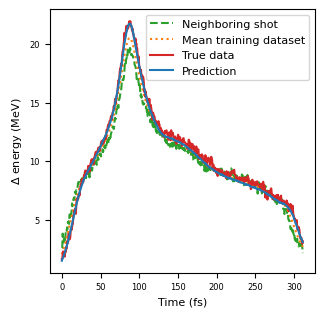

In [11]:
plot_predictions(156, predictions[0], test_data_loader)

### Plot loss and prediction


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['hp_metric', 'val_loss', 'epoch', 'lr_scheduler', 'train_loss'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
MSE: 0.11781402677297592


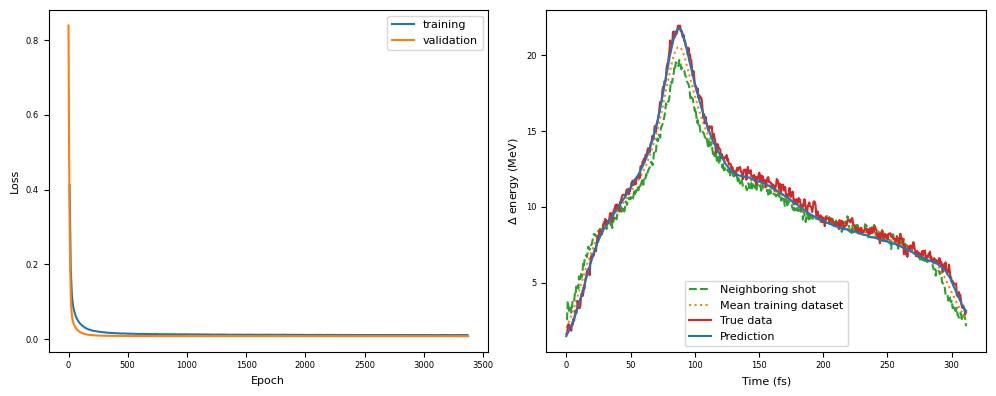

In [12]:
event_acc = EventAccumulator(trainer.lightning_module.logger.log_dir)
event_acc.Reload()
print(event_acc.Tags())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_loss(event_acc, ax=axs[0], yscale='linear')

plot_predictions(156, predictions[0], test_data_loader, ax=axs[1])
axs[1].legend(loc='lower center')
# ax[0].set_title('Prediction vs Measurement')
plt.tight_layout()
plt.show()

# save as svg
fig.savefig(local_data_path / f'training_results_penalty{penalty_weight}.svg')

### Calculate overall MSE

In [13]:
test_data = next(iter(test_data_loader))
print(test_data[1].shape)
print(predictions[0].shape)

torch.Size([282, 567])
torch.Size([282, 567])


In [14]:
test_mse = nn.MSELoss()(predictions[0], next(iter(test_data_loader))[1])
test_mse.item()

0.00878798495978117

### Compare shot-to-shot error to prediction error

In [15]:
prediction_errors = [nn.MSELoss()(predictions_n, energy_shot_n).item() for predictions_n, energy_shot_n in zip(predictions[0], test_data[1])]
mean_errors = [nn.MSELoss()(torch.tensor(mean_data), energy_shot_n).item() for energy_shot_n in test_data[1]]
shot_to_shot_errors = [nn.MSELoss()(energy_shot_n_plus_1, energy_shot_n).item() for energy_shot_n_plus_1, energy_shot_n in zip(test_data[1][1:], test_data[1][:-1])]
print(f"Prediction error: {np.mean(prediction_errors):.3f} ± {np.std(prediction_errors):.4f}")
print(f"Mean error: {np.mean(mean_errors):.3f} ± {np.std(mean_errors):.3f}")
print(f"Shot to shot error: {np.mean(shot_to_shot_errors):.2f} ± {np.std(shot_to_shot_errors):.3f}")

Prediction error: 0.009 ± 0.0052
Mean error: 0.011 ± 0.007
Shot to shot error: 0.02 ± 0.014


In [16]:
overall_shot_to_shot_error = nn.MSELoss()(test_data[1][1:], test_data[1][:-1]).item()
print(f"Overall shot to shot error: {overall_shot_to_shot_error}")
# repeat mean_data to match the length of the test data
mean_data_repeated = torch.tensor(np.asarray([mean_data] * len(test_data[1])))
mean_data_repeated.shape
overall_mean_test_error = nn.MSELoss()(mean_data_repeated, test_data[1]).item()
print(f"Overall mean test error: {overall_mean_test_error}")
overall_prediction_error = nn.MSELoss()(predictions[0][:-1], test_data[1][:-1]).item()
print(f"Overall prediction error: {overall_prediction_error}")

Overall shot to shot error: 0.022607935592532158
Overall mean test error: 0.011330978013575077
Overall prediction error: 0.00879852008074522


### Plot the overall errors as a bar plot

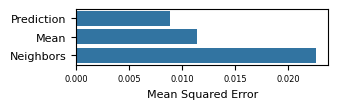

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(onecolumn, onecolumn/3))
errors = [overall_prediction_error, overall_mean_test_error, overall_shot_to_shot_error]
error_labels = ['Prediction', 'Mean', 'Neighbors']
sns.barplot(x=errors, y=error_labels, ax=axs)
axs.set_xlabel('Mean Squared Error')
# increase the font size of the y-axis ticks
axs.tick_params(axis='y', labelsize=plt.rcParams['axes.labelsize'])
plt.tight_layout()
fig.savefig(local_data_path / f'error_summary_penalty{penalty_weight}.svg')

## Statistics

In [18]:
all_errors = np.stack([prediction_errors[1:], mean_errors[1:] ,shot_to_shot_errors], axis=1)
error_labels = ['Prediction', 'Mean', 'Neighbors']
# create a dataframe with the errors and plot it as a horizontal boxplot
dataframe = pd.DataFrame(all_errors, columns=error_labels)
# convert the dataframe to a long-form dataframe
dataframe_long = dataframe.melt(var_name='error_type', value_name='error')

print("Errors: (median and interquartile range)")
for i, error_type in enumerate(error_labels):
    median_error = np.median(all_errors[:, i])
    quartile_1 = np.percentile(all_errors[:, i], 25)
    quartile_3 = np.percentile(all_errors[:, i], 75)
    print(f"{error_type}: {median_error:.3f} ({quartile_1:.4f} - {quartile_3:.4f})")
    # axs[3].text(0.04, i, f'{mean_error:.3f} ± {std_error:.4f} n={len(test_data_loader.dataset) - 1}', verticalalignment='center', fontsize=6)

Errors: (median and interquartile range)
Prediction: 0.007 (0.0056 - 0.0100)
Mean: 0.009 (0.0068 - 0.0134)
Neighbors: 0.019 (0.0132 - 0.0270)


In [19]:
dataframe

,Prediction,Mean,Neighbors
0,0.009148,0.005601,0.019617
1,0.010961,0.007740,0.014682
2,0.004329,0.007116,0.013822
3,0.012531,0.008566,0.018147
4,0.010213,0.017334,0.019496
...,...,...,...
276,0.012892,0.020567,0.046555
277,0.005710,0.004943,0.028928
278,0.011081,0.014732,0.019343
279,0.007569,0.013097,0.021301


In [20]:
# perform a wilcoxon signed-rank test to test whether predictions are significantly lower than mean and neighbors
wilcoxon_test_prediction_mean = stats.wilcoxon(dataframe['Prediction'], dataframe['Mean'])
print(f"Wilcoxon signed-rank test for prediction vs mean: {wilcoxon_test_prediction_mean}")
wilcoxon_test_prediction_neighbors = stats.wilcoxon(dataframe['Prediction'], dataframe['Neighbors'])
print(f"Wilcoxon signed-rank test for prediction vs neighbors: {wilcoxon_test_prediction_neighbors}")
wilcoxon_test_mean_neighbors = stats.wilcoxon(dataframe['Mean'], dataframe['Neighbors'])
print(f"Wilcoxon signed-rank test for mean vs neighbors: {wilcoxon_test_mean_neighbors}")

# apply a bonferroni correction to the p-values
p_values = [wilcoxon_test_prediction_mean.pvalue, wilcoxon_test_prediction_neighbors.pvalue, wilcoxon_test_mean_neighbors.pvalue]
reject, corrected_p_values, _, _ = multipletests(p_values, method='bonferroni', alpha=0.01)
print(f"Corrected p-values: {corrected_p_values}")
print(f"Reject null hypothesis: {reject}")

Wilcoxon signed-rank test for prediction vs mean: WilcoxonResult(statistic=np.float64(9603.0), pvalue=np.float64(7.060216075383809e-14))
Wilcoxon signed-rank test for prediction vs neighbors: WilcoxonResult(statistic=np.float64(980.0), pvalue=np.float64(2.1776770916385417e-43))
Wilcoxon signed-rank test for mean vs neighbors: WilcoxonResult(statistic=np.float64(1480.0), pvalue=np.float64(3.3117312942171807e-41))
Corrected p-values: [2.11806482e-13 6.53303127e-43 9.93519388e-41]
Reject null hypothesis: [ True  True  True]


## Figure

MSE: 0.11781402677297592


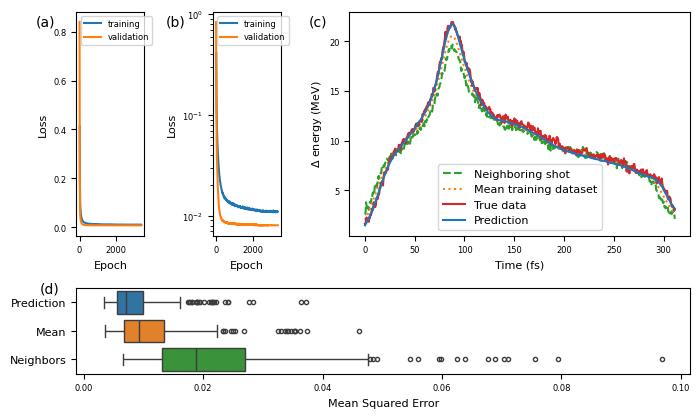

In [21]:
event_acc = EventAccumulator(trainer.lightning_module.logger.log_dir)
event_acc.Reload()
figure_grid = (3, 5)
fig = plt.figure(figsize=(textwidth, textwidth * 0.6))
# plot the training and validation loss in the top left
axs = []
axs.append(plt.subplot2grid(figure_grid, (0, 0), rowspan=2, colspan=1, fig=fig))
plot_loss(event_acc, ax=axs[0])
axs[0].set_title('(a)', x=-0.6, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'])
axs[0].legend(fontsize=6)

# plot the training and validation loss in log scale
axs.append(plt.subplot2grid(figure_grid, (0, 1), rowspan=2, colspan=1, fig=fig))
plot_loss(event_acc, ax=axs[1], yscale='log')
axs[1].set_title('(b)', x=-0.7, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'])
axs[1].legend(fontsize=6)

# plot the prediction vs measurement in the top right
axs.append(plt.subplot2grid(figure_grid, (0, 2), rowspan=2, colspan=3, fig=fig))
plot_predictions(156, predictions[0], test_data_loader, ax=axs[2])
axs[2].legend(loc='lower center')
axs[2].set_title('(c)', x=-0.12, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'])
# axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2)) # place the legend below the axis

# plot the error summary in the bottom row
axs.append(plt.subplot2grid(figure_grid, (2, 0), colspan=figure_grid[1], fig=fig))
sns.boxplot(data=dataframe, ax=axs[3], orient='h', fliersize=3)

axs[3].set_xlabel('Mean Squared Error')
# increase the font size of the y-axis ticks
axs[3].tick_params(axis='y', labelsize=plt.rcParams['axes.labelsize'])
axs[3].set_title('(d)', x=-0.06, y=1.0, loc='left', pad=-plt.rcParams['axes.titlesize'] / 3)

plt.tight_layout()

# save as svg
fig.savefig(local_data_path / f'training_results_penalty{penalty_weight}.svg')

## Benchmark the prediction

In [22]:
%%timeit
predictions = trainer.predict(mlp, test_data_loader)


/Users/korten/Documents/workspace/VPRD/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


4.67 ms ± 111 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(f"Time per shot: {4.53 * 1000 / len(test_data_loader.dataset):.1f} ± {227 / len(test_data_loader.dataset):.2f} µs")

Time per shot: 16.1 ± 0.80 µs
